In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io

predict_all = False

MainProcess


In [2]:
# Prepare datasets
if predict_all:
     res_dir = fls.result_dir + '/many_abbr_full/'
#     fls.download_kaggle_dataset('jeroencottaar/byu-many-models/', res_dir)
else:
     res_dir = fls.result_dir + '/many_abbr_res/'
     fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', res_dir)

In [9]:
# Read results from vast.ai
files = glob.glob(res_dir + '*.pickle')
dicts = []
dicts_kaggle_comp = []
for f in files:    
    print(f)
    data = fls.dill_load(f)    
    d = data.modifier_values
    
    #if not (d['seed']>=5): print('skip'); continue

    if predict_all:
        data.trained_model.data_after_step2 = data.inferred_test_data     
        data.trained_model.step3Output.threshold=-1
        data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)[2]

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    print(len(data.test_data))

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue
    
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

d:/flagellar/results//many_abbr_res\Baseline_0M_b0c276ce_742 _a.pickle
350
d:/flagellar/results//many_abbr_res\Baseline_0_bdbe5f7f_793 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_1000_bdbe5f7f_960 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_10_bdbe5f7f_716 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_1_bdbe5f7f_855 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_2_bdbe5f7f_757 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_3_bdbe5f7f_710 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_4_bdbe5f7f_798 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_5_bdbe5f7f_949 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_6_bdbe5f7f_740 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_7_bdbe5f7f_763 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_8_bdbe5f7f_821 _a.pickle
160
d:/flagellar/results//many_abbr_res\Baseline_9_bdbe5f7f_938 _a.pickle
160


In [10]:
# Load Kaggle results
if predict_all:
    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
else:
    kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [11]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    if predict_all:
        name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

In [12]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [13]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [14]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,seed,n_ensemble,scale_percentile_value,scale_std,blur_z,img_size,n_epochs,lr0,use_best_epoch,...,ycw,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,0,0,4,2.000000,False,1,640,30,0.001000,True,...,False,Baseline,b0c276cebdd242390bc031c12cc7561b1f2c2889,True,0.742507,0.863014,0.744681,0.738636,0.677321,0.610
1,1,0,4,2.079147,False,5,512,30,0.002057,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.793103,0.914634,0.849057,0.869565,0.679012,0.541
2,4,1,3,4.801855,False,5,768,68,0.000648,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.855978,0.914634,1.000000,1.000000,0.718654,0.576
3,5,2,4,2.193965,True,3,640,33,0.001259,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.757997,0.914634,0.769231,0.801105,0.652174,0.541
4,6,3,4,1.947242,True,1,768,53,0.000393,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.710267,0.939394,0.686275,0.846995,0.512821,0.548
5,7,4,4,3.045310,True,7,768,33,0.001280,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.798898,0.939394,0.849057,0.913978,0.652174,0.562
6,8,5,4,4.231763,False,7,704,41,0.000358,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.949535,0.939394,0.925926,0.869565,1.000000,0.576
7,9,6,3,2.373083,False,5,704,45,0.003072,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.740223,0.939394,0.686275,0.730337,0.652174,0.527
8,10,7,4,4.588855,False,5,768,39,0.000631,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.763889,0.939394,0.769231,0.869565,0.611285,0.603
9,11,8,4,4.949107,False,3,704,62,0.002344,False,...,False,Baseline,bdbe5f7fce5b2f1af6d44e149df1d2ec874a5898,False,0.821918,0.939394,0.925926,0.891892,0.705521,0.576


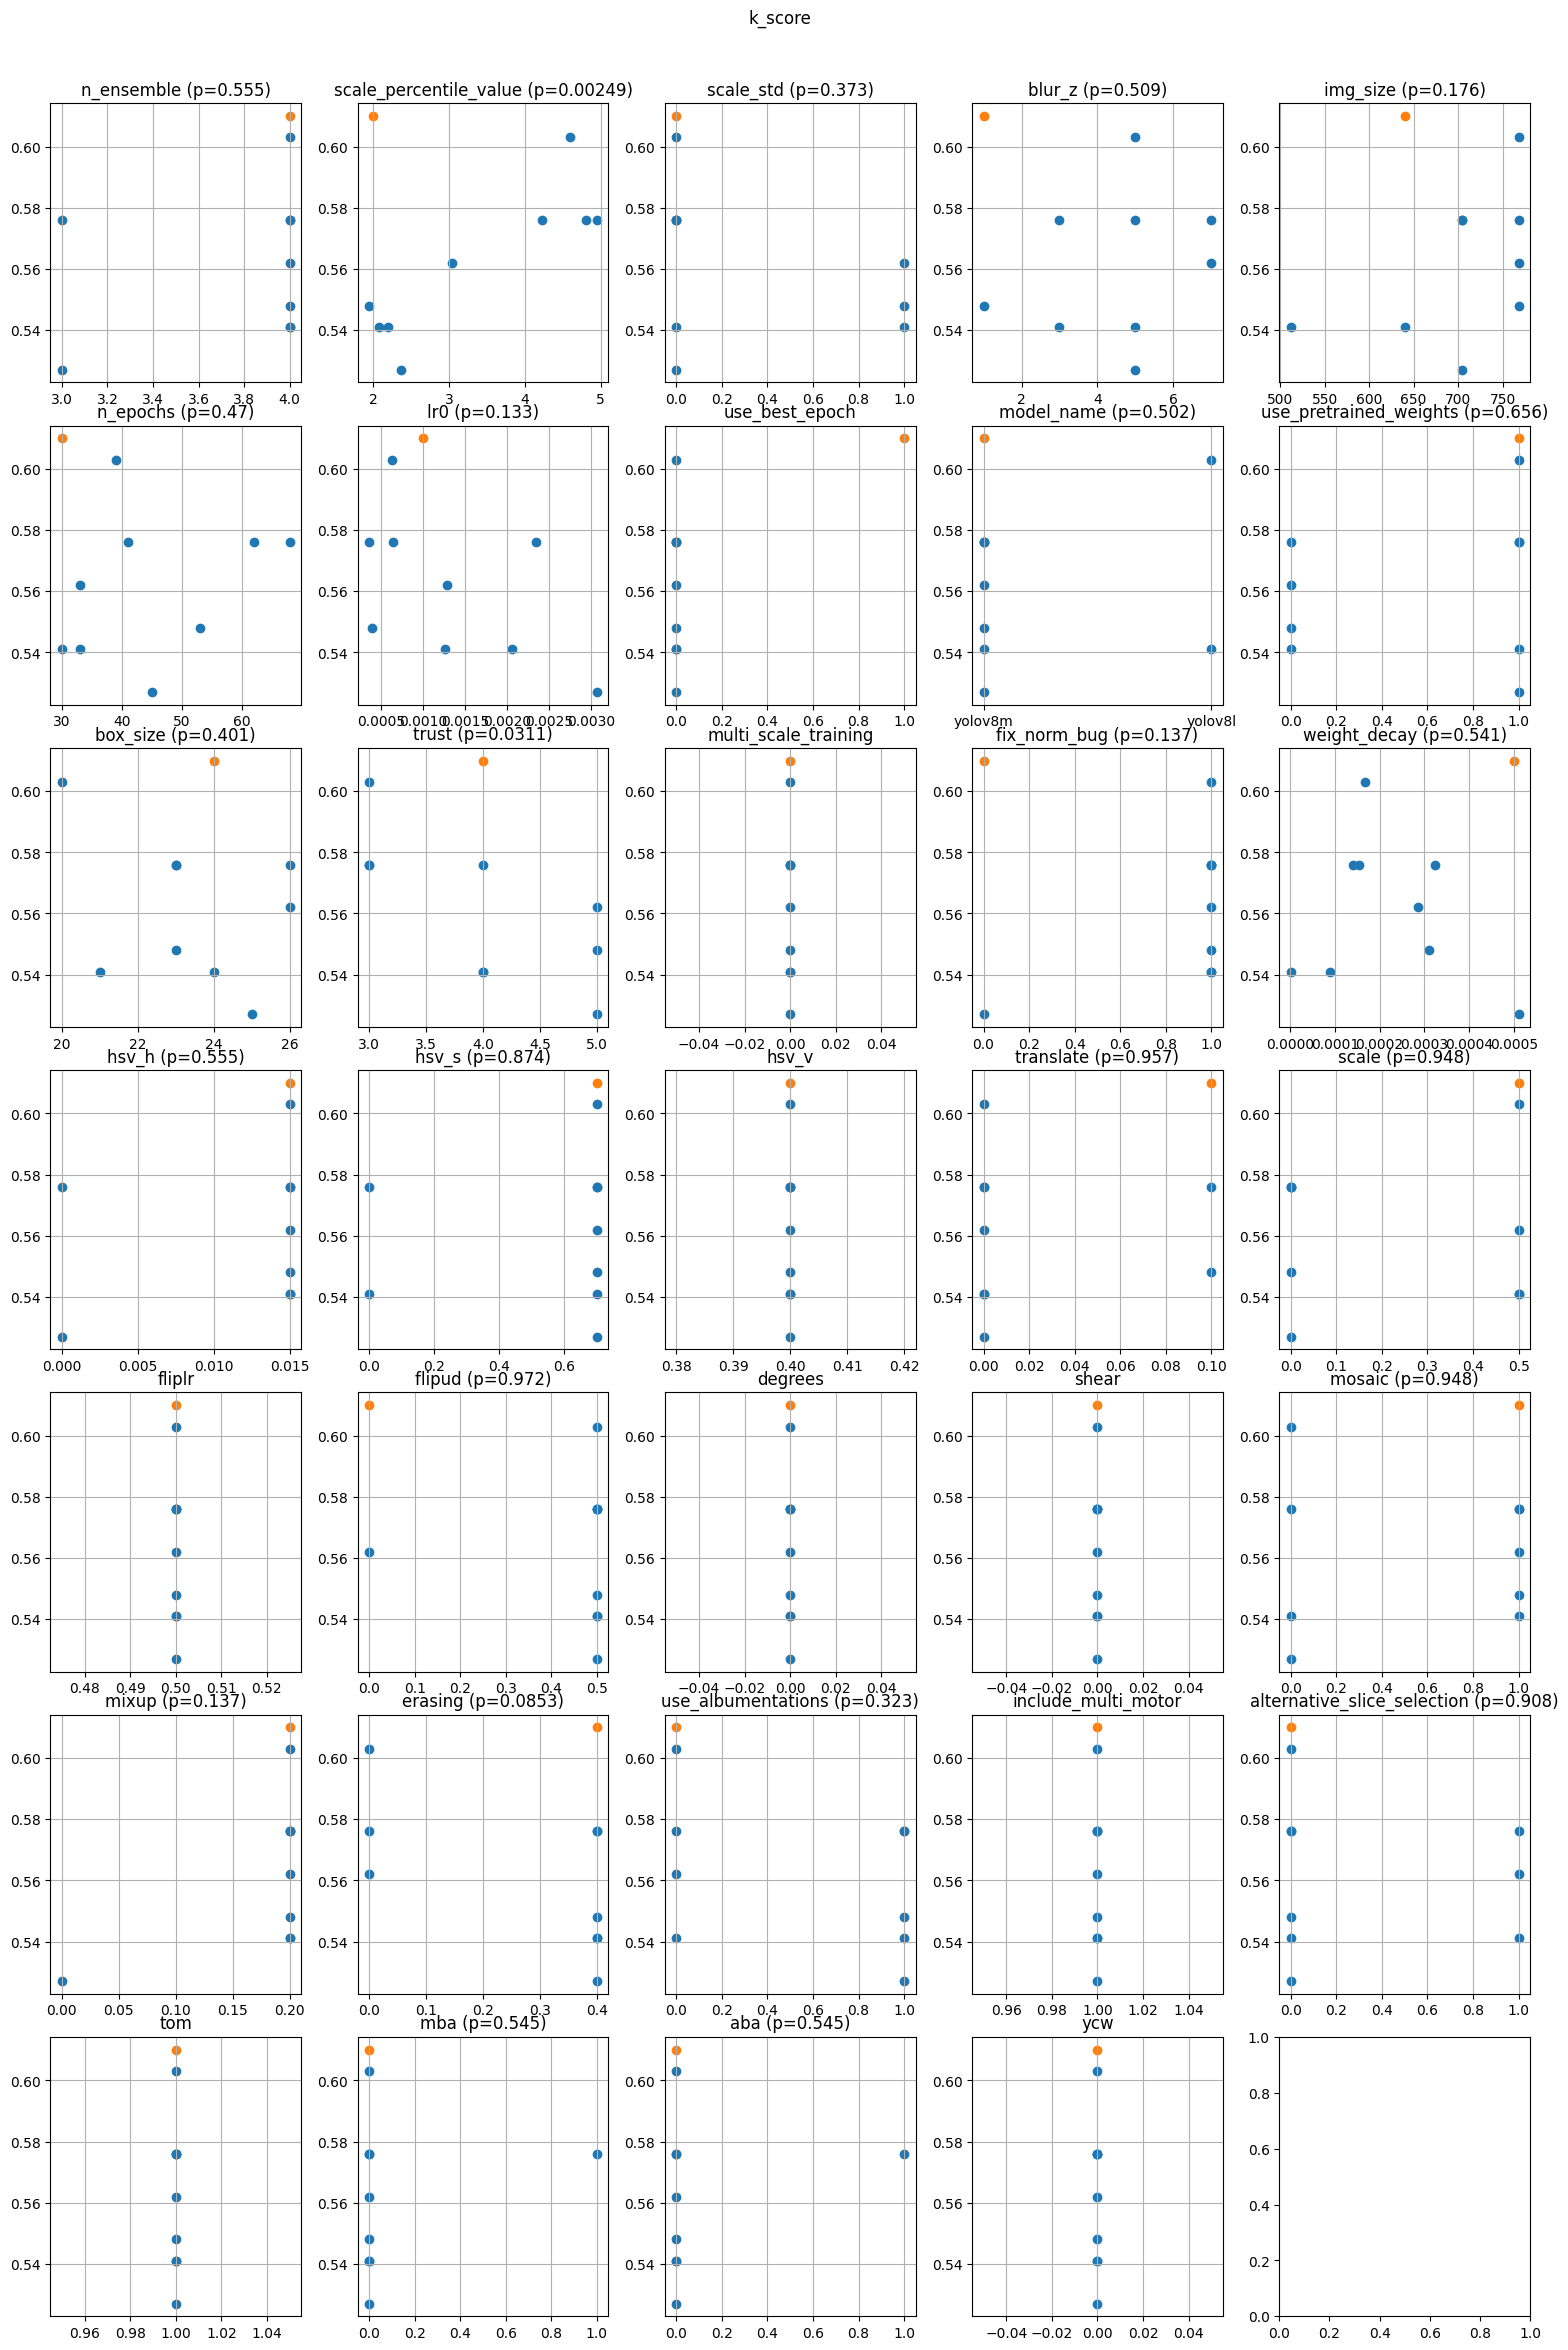

In [15]:
to_plot = copy.deepcopy(p).columns.to_list()[2:-9]
main = np.logical_and(np.logical_not(p['use_missing_value']), np.logical_not(p['cv_score']==0.))
#main = p['tom']
# for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
#      plt.figure()
#      plt.scatter(p[x_val][main], p['k_score'][main])
#      plt.grid(True)
#      plt.xlabel(x_val)
#      plt.ylabel('Kaggle score')
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
for y_val in p.columns[-6:][[5]].to_list():#,0,1,2,3,4]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        plt.scatter(p[d][main], p[y_val][main])
        if y_val == 'k_score':
            plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [ ]:
from pptx import Presentation
from pptx.util import Inches

prs = Presentation()
blank = prs.slide_layouts[6]  # a blank slide layout

for i, fig in enumerate(figs):
    # save each figure to disk
    img_path = f"figure_{i+1}.png"
    fig.savefig(img_path, dpi=300, bbox_inches='tight')

    # add a new slide, then add the image to it
    slide = prs.slides.add_slide(blank)
    slide.shapes.add_picture(
        img_path,
        Inches(1), Inches(1),          # left, top margins
        width=Inches(8)                # scale width (height auto)
    )

    os.remove(img_path)

prs.save("run_many_models_results.pptx")